In [1]:
%matplotlib inline
import tensorflow as tf
import sys
from keras.losses import binary_crossentropy
from keras.layers import Dense, InputLayer
from keras.models import Sequential

sys.path.append("../kernelflow/")

import numpy as np
from numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

from kernelflow.kernel_density import KernelDensity


Using TensorFlow backend.


In [2]:
# generate a large gaussian mixture dataset

np.random.seed(7)

s_size = 200000
b_size = 200000

s_mean = np.array([0.7,0.7])
s_cov = np.array([[0.1,0.01],[0.03,0.2]])

b_mean = np.array([0.2,0.2])
b_cov = np.array([[3.,0.6],[0.01,1.0]])

s_dat = mvn(s_mean, s_cov, s_size)
b_dat = mvn(b_mean, b_cov, b_size)
s_val = mvn(s_mean, s_cov, s_size)
b_val = mvn(b_mean, b_cov, b_size)

/Users/edward/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  
/Users/edward/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app
/Users/edward/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
/Users/edward/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


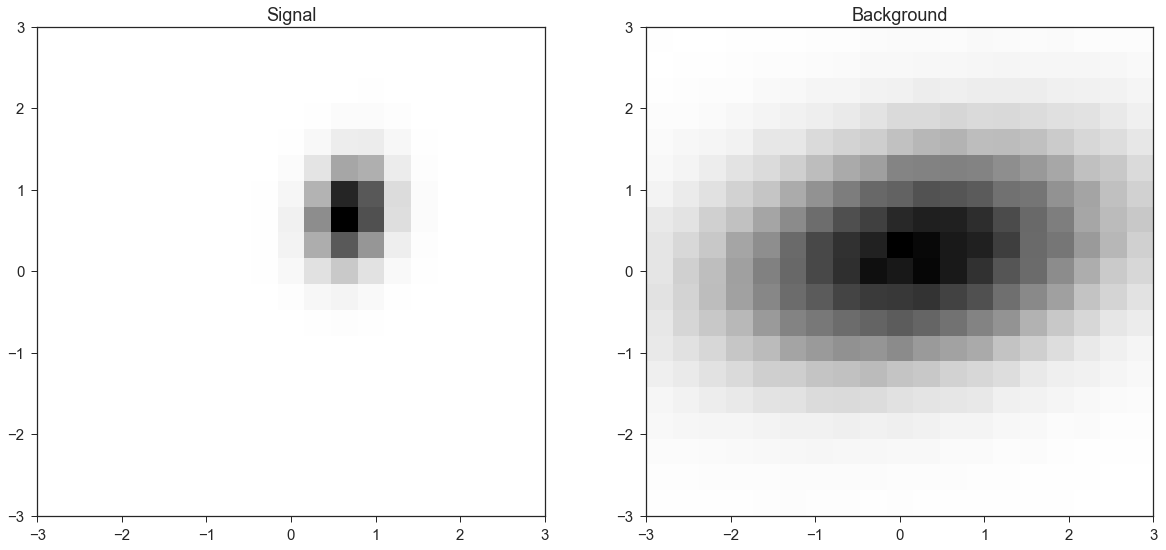

In [3]:
# explore 2d projections
fig, axs = plt.subplots(1,2, figsize=(20,9))

bins = np.linspace(-3.,3,20)
axs[0].hist2d(s_dat[:,0], s_dat[:,1], normed=True, bins=bins);
axs[0].set_title("Signal")
axs[1].hist2d(b_dat[:,0], b_dat[:,1], normed=True, bins=bins);
axs[1].set_title("Background")

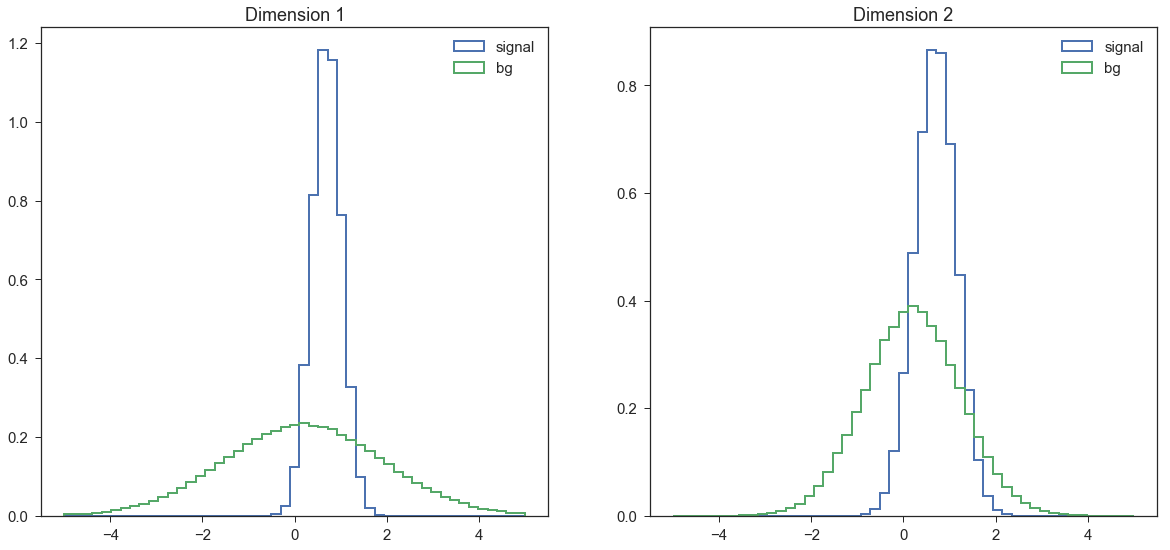

In [4]:
# explore 1d features
fig, axs = plt.subplots(1,2, figsize=(20,9))

bins = np.linspace(-5.,5,50)
axs[0].hist(s_dat[:,0],normed=True, bins=bins,histtype='step',linewidth = 2.,label='signal');
axs[0].hist(b_dat[:,0], normed=True, bins=bins,histtype='step',linewidth = 2.,label='bg');
axs[1].hist(s_dat[:,1],normed=True, bins=bins,histtype='step',linewidth = 2.,label='signal');
axs[1].hist(b_dat[:,1], normed=True, bins=bins,histtype='step',linewidth = 2.,label='bg');
axs[0].set_title('Dimension 1')
axs[1].set_title('Dimension 2')
axs[0].legend()
axs[1].legend()

In [5]:
# keras+tf dnn model

n_features = 2

m_input = tf.placeholder(tf.float32, shape=(None, n_features))
s_weights = tf.placeholder(tf.float32, shape=(None, 1))


model = Sequential()
model.add(InputLayer(input_tensor=m_input,input_shape = (None, n_features))) 
model.add(Dense(32, activation='relu')) #two relu layers w/ 32 neurons
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))

m_weights = model.get_weights()
m_output = model.output

labels = tf.placeholder(tf.float32, shape=(None, 1))

mu_asimov = tf.placeholder(tf.float32, shape=(1,))
mu_float = tf.placeholder(tf.float32, shape=(1,))

In [6]:
# batch generators
#can control proportion of signal and background 
#and the amount of signal per batch
def random_split_gen(batch_size, sig_frac_batch=0.5,
                     return_weights = True,
                     s_sum_weight=100.,b_sum_weight=1000.):
    
    s_batch = int(batch_size*sig_frac_batch)
    b_batch = batch_size-s_batch
    n_s_batch = s_dat.shape[0]//s_batch
    n_b_batch = b_dat.shape[0]//b_batch
    n_batch = min(n_s_batch,n_b_batch)
    yield n_batch # yield first nb_epoch first
    while True:
        s_ids = np.random.permutation(s_dat.shape[0]) #permutation of signal indices
        b_ids= np.random.permutation(b_dat.shape[0]) #permutation of bg indices
        for b_n in range(n_batch): #for each batch
            b_input = np.zeros((batch_size,n_features)) #create empty placeholder input array
            b_output = np.zeros((batch_size,1)) #create empty placeholder output array
            b_weight = np.zeros((batch_size,1)) #create empty placeholder weight array
            s_mask = s_ids[b_n*s_batch:(b_n+1)*s_batch] #get the current batch of signal indices
            b_input[:s_batch] = s_dat[s_mask] #put current signal batch in input array
            b_output[:s_batch] = 1. #put output for signal as 1
            b_weight[:s_batch] = s_sum_weight/float(s_batch) #build weights
            b_mask = b_ids[b_n*b_batch:(b_n+1)*b_batch] #get current batch of bg indices
            b_input[s_batch:batch_size] = b_dat[b_mask] #put current bg batch in array, immediately after signal
            b_output[s_batch:batch_size] = 0. #put output for bg as 0 
            b_weight[s_batch:batch_size] = b_sum_weight/float(b_batch) #get bg weights
            if return_weights:
                yield (b_input, b_output, b_weight)
            else:
                yield (b_input, b_output)
                

In [7]:
init = tf.global_variables_initializer()

rs_gen = random_split_gen(1024)
n_batch = rs_gen.__next__()
b_input, b_output, b_weight = rs_gen.__next__()
b_weight.sum()

1100.0

In [8]:

bw = 0.001
cut = 0.5
is_sig = tf.cast(labels, dtype=tf.bool)
is_bkg = tf.logical_not(is_sig)
sig_output = tf.boolean_mask(m_output, is_sig) #grab the signal data
bkg_output = tf.boolean_mask(m_output, is_bkg) #grab the bg data
sig_weights = tf.boolean_mask(s_weights, is_sig) #grab the signal weights
bkg_weights = tf.boolean_mask(s_weights, is_bkg) #grab the bg weights
s_kde = KernelDensity(tf.reshape(sig_output,[-1]), #create a signal kernel density centered at the outputs and weighted 
                      [bw], sig_weights )
b_kde = KernelDensity(tf.reshape(bkg_output,[-1]), #create a bg kernel density centered at the outputs and weighted
                      [bw], bkg_weights)
s_log_count = s_kde.log_cdf(cut) #get the log count for signal?
b_log_count = b_kde.log_cdf(cut) #get the log count for bg


# custom poison prob so it is defined for non-integers
def log_prob_poisson(x,rate): 
    return x * tf.log(rate) - tf.lgamma(x + 1.)-rate

# differenciable poisson asimov hessian based variance loss
def asimov_likelihood(mu_asimov, mu_float, cut=0.5, bw=0.01):
    is_sig = tf.cast(labels, dtype=tf.bool) #get signal and background output values and weights
    is_bkg = tf.logical_not(is_sig)
    sig_output = tf.boolean_mask(m_output, is_sig)
    bkg_output = tf.boolean_mask(m_output, is_bkg)
    sig_weights = tf.boolean_mask(s_weights, is_sig)
    bkg_weights = tf.boolean_mask(s_weights, is_bkg)
    s_kde = KernelDensity(tf.reshape(sig_output,[-1]), #get kernel densities objects for signal and background
                          [bw], sig_weights )
    b_kde = KernelDensity(tf.reshape(bkg_output,[-1]),
                          [bw], bkg_weights)
    s_log_count = s_kde.log_cdf(cut)
    b_log_count = b_kde.log_cdf(cut)  
    #calculate the likelihood
    return log_prob_poisson(mu_asimov*tf.reduce_sum(sig_weights)*tf.exp(s_log_count)+ #x = mu_asimov * s + b
                            tf.reduce_sum(bkg_weights)*tf.exp(b_log_count),
                            mu_float*tf.reduce_sum(sig_weights)*tf.exp(s_log_count)+ #rate = mu_float * s + b
                            tf.reduce_sum(bkg_weights)*tf.exp(b_log_count))

#approximation of the significance with the significance,
#only valid under specific conditions
def simple_sig(cut=0.5, bw=0.01):
    is_sig = tf.cast(labels, dtype=tf.bool) #grab signal and background outputs and weights, build corresponding kdes
    is_bkg = tf.logical_not(is_sig)
    sig_output = tf.boolean_mask(m_output, is_sig)
    bkg_output = tf.boolean_mask(m_output, is_bkg)
    sig_weights = tf.boolean_mask(s_weights, is_sig)
    bkg_weights = tf.boolean_mask(s_weights, is_bkg)
    s_kde = KernelDensity(tf.reshape(sig_output,[-1]),
                          [bw], sig_weights )
    b_kde = KernelDensity(tf.reshape(bkg_output,[-1]),
                          [bw], bkg_weights)
    s_log_count = s_kde.log_cdf(cut) 
    b_log_count = b_kde.log_cdf(cut)
    return tf.reduce_sum(sig_weights)*tf.exp(s_log_count)/tf.sqrt(tf.reduce_sum(bkg_weights)*tf.exp(b_log_count))
    

simple_sig_no_cut = simple_sig(0.0,1e-6) #simple sig results from kde with different cuts
simple_sig_half = simple_sig(0.5,1e-6)
asimov_mu_ll = asimov_likelihood(mu_asimov,mu_float,cut=0.5, bw=0.1) #bw = 0.1 estimates from kde
asimov_zero_ll = asimov_likelihood(mu_asimov,0,cut=0.5, bw=0.1)
sig_ll_ratio = tf.sqrt(-2.*(asimov_zero_ll-asimov_mu_ll))[0]
asimov_mu_ll_exact = asimov_likelihood(mu_asimov,mu_float,cut=0.5, bw=1.e-6)  #bw = 1e-6 estimates from kde
asimov_zero_ll_exact = asimov_likelihood(mu_asimov,0,cut=0.5, bw=1.e-6)
sig_ll_ratio_exact = tf.sqrt(-2.*(asimov_zero_ll_exact-asimov_mu_ll_exact))[0]

#mu_ll is the fraction of signal, want to fit mu
hess = - tf.hessians(asimov_mu_ll, mu_float)[0] #-hessian of asimov_mu_ll w.r.t mu_float
inv_hess = tf.matrix_inverse(hess)[0] #inverse of -hessian

#gaussian approximation of the significance
sig_hess = tf.sqrt(mu_asimov**2/inv_hess)[0] # sqrt(mu^2/H^{-1})

In [9]:
def better_sig(s,b):
    return np.sqrt(2.*((s+b)*np.log(1+s/b)-s))

(1.5, 2.5)

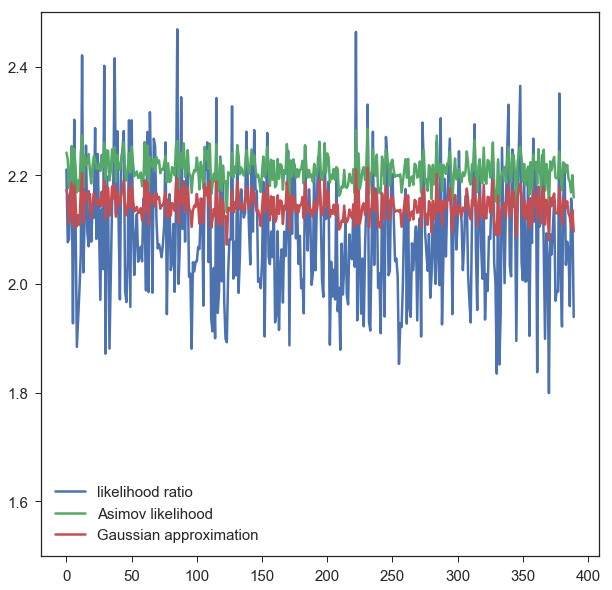

In [10]:
init = tf.global_variables_initializer()

rs_gen = random_split_gen(1024)
n_batch = rs_gen.__next__()


simple_sig_arr = np.zeros(n_batch)
sig_ll_ratio_arr = np.zeros(n_batch)
sig_hess_arr = np.zeros(n_batch)
with tf.Session() as sess:
    sess.run([init])
    for b_n in range(n_batch):
        b_input, b_output, b_weight = rs_gen.__next__()
        var_dict = {m_input : b_input,
            labels: b_output,
            s_weights : b_weight,
            mu_asimov : [1.],
            mu_float : [1.]}
        simple_sig_arr[b_n] = simple_sig_half.eval(var_dict)
        sig_ll_ratio_arr[b_n] = sig_ll_ratio.eval(var_dict)
        sig_hess_arr[b_n] = sig_hess.eval(var_dict)

        
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(np.arange(n_batch), simple_sig_arr,label='likelihood ratio') #plot the likelihoods for each batch from each of the different methods.
ax.plot(np.arange(n_batch), sig_ll_ratio_arr,label='Asimov likelihood')
ax.plot(np.arange(n_batch), sig_hess_arr,label='Gaussian approximation')
plt.legend()
ax.set_ylim([1.5, 2.5])

In [12]:
bce = tf.reduce_mean(binary_crossentropy(labels,m_output)) #build cross entropy
train_bce = tf.train.GradientDescentOptimizer(0.01).minimize(bce, var_list=model.weights) #set to minimize bce

n_epoch = 10

rs_gen = random_split_gen(128) #batch size of 128
n_batch = rs_gen.__next__()

rs_val_gen = random_split_gen(20000) #batch size of 20000
n_batch_val = rs_val_gen.__next__()
v_input, v_output, v_weight = rs_val_gen.__next__()
v_is_sig = (v_output == 1) #get masks
v_is_bkg = (v_output == 0)

wps = np.linspace(0.1,0.9,20)

#initialize things

sig_ll_ratio_arr = np.zeros((n_epoch,n_batch)) 
sig_ll_ratio_exact_arr = np.zeros((n_epoch,n_batch))
sig_ll_ratio_val_arr = np.zeros((n_epoch, wps.shape[0]))
sig_hess_arr = np.zeros((n_epoch,n_batch)) 
bce_arr = np.zeros((n_epoch,n_batch))

with tf.Session() as sess:
    sess.run([init])
    for e_n in range(n_epoch): #for each epoch
        for b_n in range(n_batch): #for each batch
            b_input, b_output, b_weight = rs_gen.__next__() #get the input, output, and weights
            var_dict = {m_input : b_input,
                labels: b_output,
                s_weights : b_weight,
                mu_asimov : [1.],
                mu_float : [1.]}
            sess.run([train_bce], var_dict) #train to minimize bce
            sig_ll_ratio_arr[e_n,b_n] = sig_ll_ratio.eval(var_dict) #evaluate on data 
            sig_ll_ratio_exact_arr[e_n,b_n] = sig_ll_ratio_exact.eval(var_dict)
            sig_hess_arr[e_n,b_n] = sig_hess.eval(var_dict)
            bce_arr[e_n,b_n] = bce.eval(var_dict)
        pred_val = m_output.eval({m_input: v_input}) #get predictions
        for w_n, wp in enumerate(wps):
            s = np.sum(v_weight[v_is_sig][pred_val[v_is_sig] > wp])
            b = np.sum(v_weight[v_is_bkg][pred_val[v_is_bkg] > wp])
            sig_ll_ratio_val_arr[e_n,w_n] = better_sig(s,b)
        


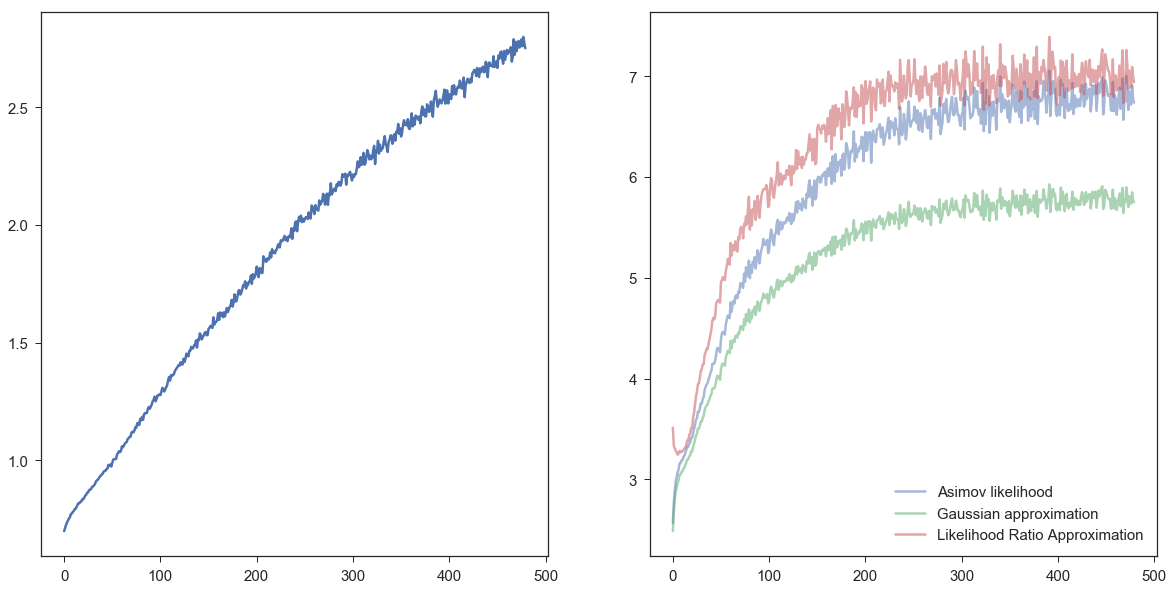

In [21]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(np.arange(n_batch*n_epoch), bce_arr.flatten())

axs[1].plot(np.arange(n_batch*n_epoch), sig_ll_ratio_arr.flatten(), alpha=0.5,label="Asimov likelihood")
axs[1].plot(np.arange(n_batch*n_epoch), sig_hess_arr.flatten(),alpha=0.5,label="Gaussian approximation")
axs[1].plot(np.arange(n_batch*n_epoch), sig_ll_ratio_exact_arr.flatten(),alpha=0.5,label="Likelihood Ratio Approximation")
plt.legend()

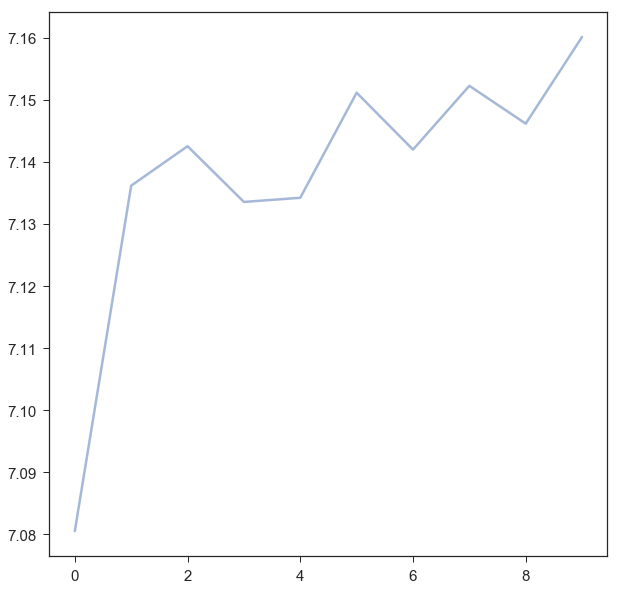

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(np.arange(n_epoch), np.nanmax(sig_ll_ratio_val_arr,axis=1),alpha=0.5)
#ax.set_ylim(7.,7.2)

In [15]:
asimov_sig_loss = - sig_ll_ratio
#train to maximize sig ll ratio
train_asimov_sig = tf.train.GradientDescentOptimizer(0.01).minimize(asimov_sig_loss, var_list=model.weights)

n_epoch = 10

rs_gen = random_split_gen(8192) #larger because of noise
n_batch = rs_gen.__next__()

# initialize variables 

simple_sig_arr = np.zeros((n_epoch,n_batch))
sig_ll_ratio_arr = np.zeros((n_epoch,n_batch))
sig_ll_ratio_exact_arr = np.zeros((n_epoch,n_batch))
sig_hess_arr = np.zeros((n_epoch,n_batch))
bce_arr = np.zeros((n_epoch,n_batch))
sig_ll_ratio_val_arr = np.zeros((n_epoch, wps.shape[0]))


with tf.Session() as sess:
    sess.run([init])
    for e_n in range(n_epoch):
        for b_n in range(n_batch):
            b_input, b_output, b_weight = rs_gen.__next__()
            var_dict = {m_input : b_input,
                labels: b_output,
                s_weights : b_weight,
                mu_asimov : [1.],
                mu_float : [1.]}
            sess.run([train_asimov_sig ], var_dict)
            simple_sig_arr[e_n,b_n] = simple_sig_half.eval(var_dict)
            sig_ll_ratio_arr[e_n,b_n] = sig_ll_ratio.eval(var_dict)
            sig_ll_ratio_exact_arr[e_n,b_n] = sig_ll_ratio_exact.eval(var_dict)
            sig_hess_arr[e_n,b_n] = sig_hess.eval(var_dict)
            bce_arr[e_n,b_n] = bce.eval(var_dict)
        pred_val = m_output.eval({m_input: v_input})
        for w_n, wp in enumerate(wps):
            s = np.sum(v_weight[v_is_sig][pred_val[v_is_sig] > wp])
            b = np.sum(v_weight[v_is_bkg][pred_val[v_is_bkg] > wp])
            sig_ll_ratio_val_arr[e_n,w_n] = better_sig(s,b)
        
        

/Users/edward/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


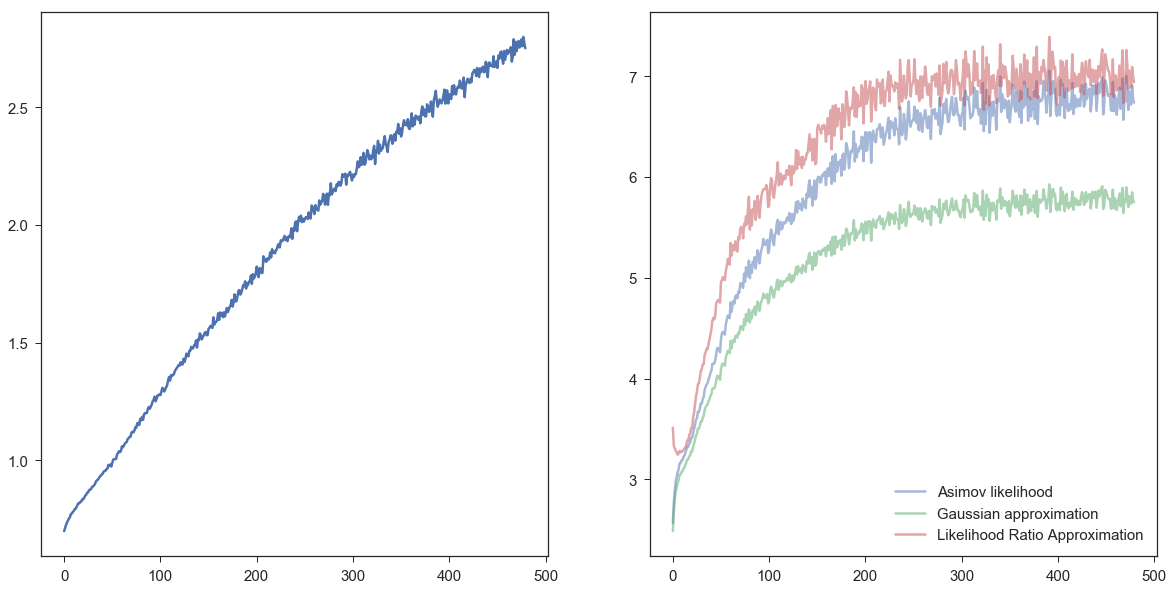

In [22]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(np.arange(n_batch*n_epoch), bce_arr.flatten())

axs[1].plot(np.arange(n_batch*n_epoch), sig_ll_ratio_arr.flatten(), alpha=0.5,label="Asimov likelihood")
axs[1].plot(np.arange(n_batch*n_epoch), sig_hess_arr.flatten(),alpha=0.5,label="Gaussian approximation")
axs[1].plot(np.arange(n_batch*n_epoch), sig_ll_ratio_exact_arr.flatten(),alpha=0.5,label="Likelihood Ratio Approximation")
plt.legend()

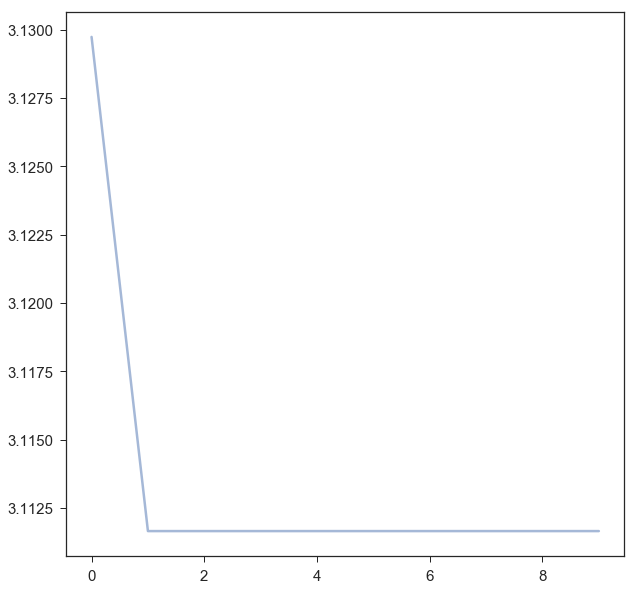

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(np.arange(n_epoch), np.nanmax(sig_ll_ratio_val_arr,axis=1),alpha=0.5)
#ax.set_ylim(7,7.2)

In [18]:
asimov_sig_loss = - sig_ll_ratio
sig_hess_loss = - sig_hess
#train to maximize sig ll ratio
train_asimov_sig = tf.train.GradientDescentOptimizer(0.01).minimize(sig_hess_loss, var_list=model.weights)

n_epoch = 10

rs_gen = random_split_gen(8192) #larger because of noise
n_batch = rs_gen.__next__()

# initialize variables 

simple_sig_arr = np.zeros((n_epoch,n_batch))
sig_ll_ratio_arr = np.zeros((n_epoch,n_batch))
sig_ll_ratio_exact_arr = np.zeros((n_epoch,n_batch))
sig_hess_arr = np.zeros((n_epoch,n_batch))
bce_arr = np.zeros((n_epoch,n_batch))
sig_ll_ratio_val_arr = np.zeros((n_epoch, wps.shape[0]))


with tf.Session() as sess:
    sess.run([init])
    for e_n in range(n_epoch):
        for b_n in range(n_batch):
            b_input, b_output, b_weight = rs_gen.__next__()
            var_dict = {m_input : b_input,
                labels: b_output,
                s_weights : b_weight,
                mu_asimov : [1.],
                mu_float : [1.]}
            sess.run([train_asimov_sig ], var_dict)
            simple_sig_arr[e_n,b_n] = simple_sig_half.eval(var_dict)
            sig_ll_ratio_arr[e_n,b_n] = sig_ll_ratio.eval(var_dict)
            sig_ll_ratio_exact_arr[e_n,b_n] = sig_ll_ratio_exact.eval(var_dict)
            sig_hess_arr[e_n,b_n] = sig_hess.eval(var_dict)
            bce_arr[e_n,b_n] = bce.eval(var_dict)
        pred_val = m_output.eval({m_input: v_input})
        for w_n, wp in enumerate(wps):
            s = np.sum(v_weight[v_is_sig][pred_val[v_is_sig] > wp])
            b = np.sum(v_weight[v_is_bkg][pred_val[v_is_bkg] > wp])
            sig_ll_ratio_val_arr[e_n,w_n] = better_sig(s,b)
        
        

/Users/edward/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


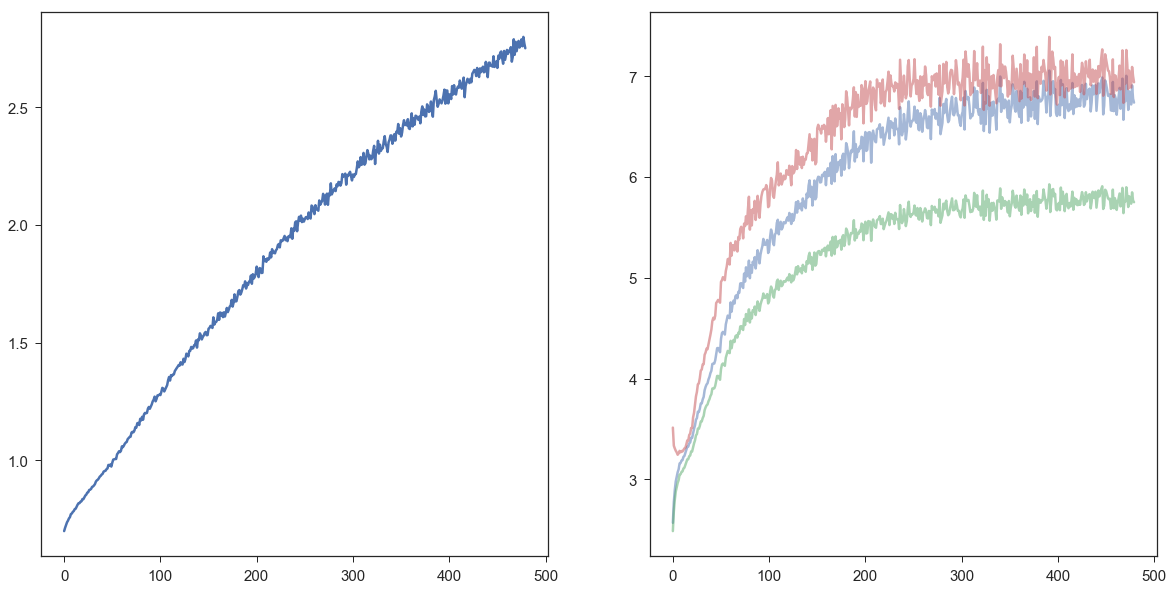

In [19]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(np.arange(n_batch*n_epoch), bce_arr.flatten())

axs[1].plot(np.arange(n_batch*n_epoch), sig_ll_ratio_arr.flatten(), alpha=0.5)
axs[1].plot(np.arange(n_batch*n_epoch), sig_hess_arr.flatten(),alpha=0.5)
axs[1].plot(np.arange(n_batch*n_epoch), sig_ll_ratio_exact_arr.flatten(),alpha=0.5)

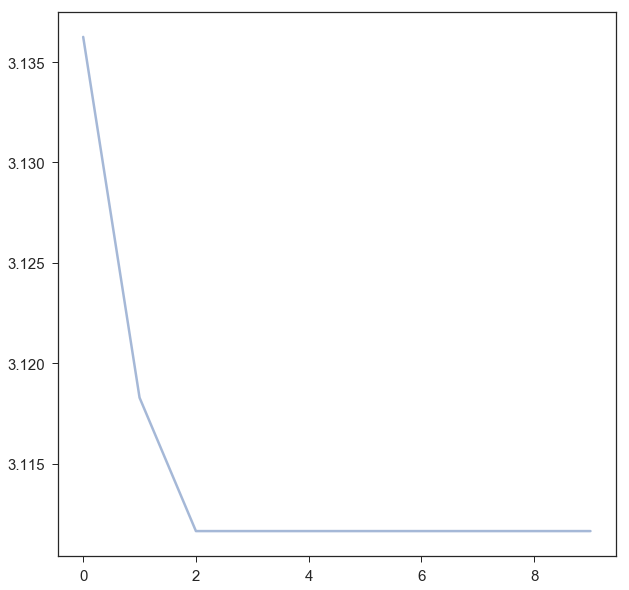

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(np.arange(n_epoch), np.nanmax(sig_ll_ratio_val_arr,axis=1),alpha=0.5)
#ax.set_ylim(7,7.2)